## Text Classification with Transfer Learning

### Importing Drug Reviews dataset

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [2]:
 !ls "/content/drive/MyDrive/EAI6010/drug+review+dataset+drugs+com"

drugsComTest_raw.tsv  drugsComTrain_raw.tsv


In [3]:
cd "/content/drive/MyDrive/EAI6010/drug+review+dataset+drugs+com"

/content/drive/MyDrive/EAI6010/drug+review+dataset+drugs+com


In [4]:
!ls -la


total 109728
-rw------- 1 root root 28071166 Oct  2  2018 drugsComTest_raw.tsv
-rw------- 1 root root 84289175 Oct  2  2018 drugsComTrain_raw.tsv


In [5]:
import pandas as pd

# Load the training and test datasets
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

# Inspect the datasets
print("Train Data:")
print(train_data.info())

print("\nTest Data:")
print(test_data.info())




Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB
None

Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date 

In [6]:
test_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [7]:
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


Data procesing on test and train dataset
* Drop Unnamed: 0 Column
* Clean the review Column: Remove unwanted characters, such as: (Prolly use acsii code to convert characters like "#039" to " '(single quote)"puncatation marks)
* Convert the text to lowercase for uniformity.
* Clean drugName by:
    * Handling alphanumeric terms or special characters (if needed).
* Add Sentiment Labels
  * Create binary sentiment labels based on rating:
  * Positive Sentiment: rating > 5
  * Negative Sentiment: rating <= 5






### Data Processing

In [9]:
test_data.drop('Unnamed: 0', axis=1, inplace=True)
train_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.head()


KeyError: "['Unnamed: 0'] not found in axis"

In [10]:
train_data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [11]:
# Function to extract non-ASCII characters(NAC) from text
def find_non_ascii_chars(text):
    return ''.join(char for char in text if ord(char) > 127)

# Finding NAC
train_data['non_ascii'] = train_data['review'].apply(find_non_ascii_chars)
test_data['non_ascii'] = test_data['review'].apply(find_non_ascii_chars)

# rows with NAC
non_ascii_train = train_data[train_data['non_ascii'] != '']
non_ascii_test = test_data[test_data['non_ascii'] != '']

# NAC in that row
print("Non-ASCII characters in train data:")
print(non_ascii_train[['review', 'non_ascii']].head())

print("\nNon-ASCII characters in test data:")
print(non_ascii_test[['review', 'non_ascii']].head())
print("\nNumber of reviews with non-ASCII characters in train data:", len(non_ascii_train))
print("Number of reviews with non-ASCII characters in test data:", len(non_ascii_test))


Non-ASCII characters in train data:
                                                 review non_ascii
117   "I love Lutera. I am very sensitive to other f...         ☺
168   "My Endo insisted I switch from lantus to tres...         ​
3615  "Hi Ladies I wanted to share my experience wit...         ❤
3742  "Been on Seasonale for 5 weeks. Results are va...         ​
3802  "I️ have noticed that my periods have become b...     ️️️️️

Non-ASCII characters in test data:
                                                 review non_ascii
2525  "This medication saved my life I suffered with...        ❤️
2634  "My Dr had put me on opana 60 mg twice daily A...         ​
3513  "Hi Ladies I wanted to share my experience wit...         ❤
6631  "I have been on this pill for about 10 months ...         ❤
7146  "Started Phentermine 37.5mg about 10 days ago....        ❤️

Number of reviews with non-ASCII characters in train data: 121
Number of reviews with non-ASCII characters in test data: 40


ref: https://deysusovan93.medium.com/text-cleaning-the-secret-weapon-for-smarter-nlp-models-part-2-9c22b2f1bcd

#### Removing Emojis from data (One type of non ascii char)

In [12]:
!pip install emoji
import emoji

# Remove emojis from text
def remove_emojis(text):
    return ''.join(char for char in text if char not in emoji.EMOJI_DATA)  # 'en' for English emojis

# Apply the function to train and test datasets
train_data['cleaned_review'] = train_data['review'].apply(remove_emojis)
test_data['cleaned_review'] = test_data['review'].apply(remove_emojis)

# Display cleaned reviews
train_data[['review', 'cleaned_review']].head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 5.7 MB/s eta 0:00:00
                                              review  \
0  "It has no side effect, I take it in combinati...   
1  "My son is halfway through his fourth week of ...   
2  "I used to take another oral contraceptive, wh...   
3  "This is my first time using any form of birth...   
4  "Suboxone has completely turned my life around...   

                                      cleaned_review  
0  "It has no side effect, I take it in combinati...  
1  "My son is halfway through his fourth week of ...  
2  "I used to take another oral contraceptive, wh...  
3  "This is my first time using any form of birth...  
4  "Suboxone has completely turned my life around...  


In [13]:
def find_non_ascii_chars(text):
    return ''.join(char for char in text if ord(char) > 127)

# Finding NAC
train_data['non_ascii'] = train_data['cleaned_review'].apply(find_non_ascii_chars)
test_data['non_ascii'] = test_data['cleaned_review'].apply(find_non_ascii_chars)
# rows with NAC
non_ascii_train = train_data[train_data['non_ascii'] != '']
non_ascii_test = test_data[test_data['non_ascii'] != '']

# NAC in that row
print("Non-ASCII characters in train data:")
print(non_ascii_train[['review', 'non_ascii']].head())
# rows with NAC
non_ascii_train = train_data[train_data['non_ascii'] != '']
non_ascii_test = test_data[test_data['non_ascii'] != '']
print("\nNumber of reviews with non-ASCII characters in train data:", len(non_ascii_train))
print("Number of reviews with non-ASCII characters in test data:", len(non_ascii_test))

Non-ASCII characters in train data:
                                                 review non_ascii
168   "My Endo insisted I switch from lantus to tres...         ​
3742  "Been on Seasonale for 5 weeks. Results are va...         ​
3802  "I️ have noticed that my periods have become b...     ️️️️️
4971  "So I had unprotected sex with my boyfriend on...         ツ
6410  "Oh. My. Goodness. Am used to yeast infections...         ️

Number of reviews with non-ASCII characters in train data: 89
Number of reviews with non-ASCII characters in test data: 28


###### Let's remove any remaining non-ASCII characters from the cleaned_review column using the remove_non_ascii function.

In [14]:
# Function to remove all non-ASCII characters
def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128) # Unit till 127 is ascii char

# Apply the function to remove non-ASCII characters
train_data['cleaned_review'] = train_data['cleaned_review'].apply(remove_non_ascii)
test_data['cleaned_review'] = test_data['cleaned_review'].apply(remove_non_ascii)

# Verify cleaning
train_data['non_ascii'] = train_data['cleaned_review'].apply(find_non_ascii_chars)
test_data['non_ascii'] = test_data['cleaned_review'].apply(find_non_ascii_chars)

# Count remaining non-ASCII rows
non_ascii_train = train_data[train_data['non_ascii'] != '']
non_ascii_test = test_data[test_data['non_ascii'] != '']

print("Number of reviews with non-ASCII characters in train data after cleaning:", len(non_ascii_train))
print("Number of reviews with non-ASCII characters in test data after cleaning:", len(non_ascii_test))


Number of reviews with non-ASCII characters in train data after cleaning: 0
Number of reviews with non-ASCII characters in test data after cleaning: 0


In [15]:
test_data.head()

,drugName,condition,review,rating,date,usefulCount,non_ascii,cleaned_review
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22,,"""I&#039;ve tried a few antidepressants over th..."
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17,,"""My son has Crohn&#039;s disease and has done ..."
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3,,"""Quick reduction of symptoms"""
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,,"""Contrave combines drugs that were used for al..."
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4,,"""I have been on this birth control for one cyc..."


Dealing with HTML Entities
ref: https://www.w3schools.com/html/html_entities.asp

In [16]:
import html

# Decode HTML entities in the reviews
train_data['cleaned_review'] = train_data['cleaned_review'].apply(html.unescape)
test_data['cleaned_review'] = test_data['cleaned_review'].apply(html.unescape)

test_data[['review', 'cleaned_review']].head()


,review,cleaned_review
0,"""I&#039;ve tried a few antidepressants over th...","""I've tried a few antidepressants over the yea..."
1,"""My son has Crohn&#039;s disease and has done ...","""My son has Crohn's disease and has done very ..."
2,"""Quick reduction of symptoms""","""Quick reduction of symptoms"""
3,"""Contrave combines drugs that were used for al...","""Contrave combines drugs that were used for al..."
4,"""I have been on this birth control for one cyc...","""I have been on this birth control for one cyc..."


In [17]:
train_data.head()

,drugName,condition,review,rating,date,usefulCount,non_ascii,cleaned_review
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,,"""It has no side effect, I take it in combinati..."
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,,"""My son is halfway through his fourth week of ..."
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,,"""I used to take another oral contraceptive, wh..."
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,,"""This is my first time using any form of birth..."
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,,"""Suboxone has completely turned my life around..."


In [18]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())  # Lemmatization
    return text

train_data['cleaned_review'] = train_data['cleaned_review'].apply(preprocess_text)
test_data['cleaned_review'] = test_data['cleaned_review'].apply(preprocess_text)

train_data.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...


,drugName,condition,review,rating,date,usefulCount,non_ascii,cleaned_review
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,,it ha no side effect i take it in combination ...
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,,my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,,i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,,this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,,suboxone ha completely turned my life around i...


In [19]:
# Add sentiment labels based on the rating
train_data['sentiment'] = train_data['rating'].apply(lambda x: 'positive' if x > 5 else 'negative')
test_data['sentiment'] = test_data['rating'].apply(lambda x: 'positive' if x > 5 else 'negative')

train_data.head()


,drugName,condition,review,rating,date,usefulCount,non_ascii,cleaned_review,sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,,it ha no side effect i take it in combination ...,positive
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,,my son is halfway through his fourth week of i...,positive
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,,i used to take another oral contraceptive whic...,negative
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,,this is my first time using any form of birth ...,positive
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,,suboxone ha completely turned my life around i...,positive


In [20]:
test_data.head()

,drugName,condition,review,rating,date,usefulCount,non_ascii,cleaned_review,sentiment
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22,,ive tried a few antidepressant over the year c...,positive
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17,,my son ha crohn disease and ha done very well ...,positive
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3,,quick reduction of symptom,positive
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,,contrave combine drug that were used for alcoh...,positive
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4,,i have been on this birth control for one cycl...,positive


In [21]:

train_data = train_data[['cleaned_review', 'sentiment', 'drugName', 'condition', 'rating', 'usefulCount']]
test_data = test_data[['cleaned_review', 'sentiment', 'drugName', 'condition', 'rating', 'usefulCount']]

# Verify the changes
train_data.head()

,cleaned_review,sentiment,drugName,condition,rating,usefulCount
0,it ha no side effect i take it in combination ...,positive,Valsartan,Left Ventricular Dysfunction,9.0,27
1,my son is halfway through his fourth week of i...,positive,Guanfacine,ADHD,8.0,192
2,i used to take another oral contraceptive whic...,negative,Lybrel,Birth Control,5.0,17
3,this is my first time using any form of birth ...,positive,Ortho Evra,Birth Control,8.0,10
4,suboxone ha completely turned my life around i...,positive,Buprenorphine / naloxone,Opiate Dependence,9.0,37


In [22]:
test_data.head()

,cleaned_review,sentiment,drugName,condition,rating,usefulCount
0,ive tried a few antidepressant over the year c...,positive,Mirtazapine,Depression,10.0,22
1,my son ha crohn disease and ha done very well ...,positive,Mesalamine,"Crohn's Disease, Maintenance",8.0,17
2,quick reduction of symptom,positive,Bactrim,Urinary Tract Infection,9.0,3
3,contrave combine drug that were used for alcoh...,positive,Contrave,Weight Loss,9.0,35
4,i have been on this birth control for one cycl...,positive,Cyclafem 1 / 35,Birth Control,9.0,4


In [23]:
trad_nlp_train_data = train_data.copy() # 2nd part of Assignment
trad_nlp_test_data = test_data.copy()

###  Deep Learning Model Building

In [24]:
!pip install fastai


In [25]:
train_data = train_data.sample(n=10000, random_state=42)

# Ensure you reset the index after sampling
train_data.reset_index(drop=True, inplace=True)


In [26]:
train_data.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'}, inplace=True)
test_data.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'}, inplace=True)

<ipython-input-26-7e112c79b99b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'}, inplace=True)


In [27]:
from fastai.text.all import *


# Create DataLoaders from the dataframe
dls = TextDataLoaders.from_df(
    train_data,
    text_col='text',
    label_col='label',
    valid_pct=0.2,
    text_vocab=None,
    bs=64  # Adjust batch size as needed
)




In [28]:
 #Initialize AWD_LSTM learner
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.2, metrics= accuracy)

# Fine-tune the model with ULMFiT
learn.fine_tune(1)


/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

epoch,train_loss,valid_loss,accuracy,time
0,0.635115,0.582141,0.700500,14:13


epoch,train_loss,valid_loss,accuracy,time
0,0.512088,0.482393,0.775000,33:47


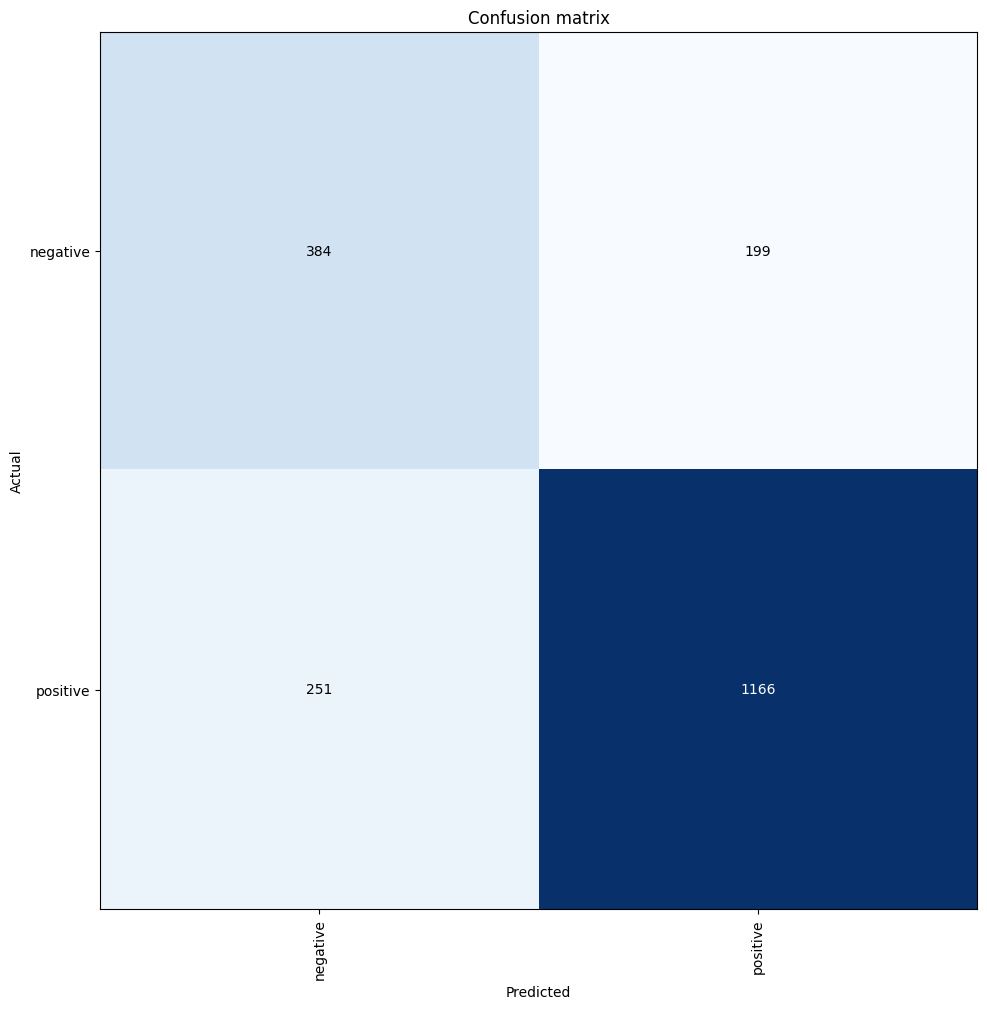

In [29]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix( figsize =(10,10)) # Confusion matrix after 1 epoch

In [30]:
learn.fine_tune(1) #2nd Epoch

epoch,train_loss,valid_loss,accuracy,time
0,0.451386,0.484514,0.774500,14:48


epoch,train_loss,valid_loss,accuracy,time
0,0.417140,0.454028,0.794500,35:14


epoch,train_loss,valid_loss,accuracy,time
0,0.362850,0.474538,0.782500,15:06


epoch,train_loss,valid_loss,accuracy,time
0,0.342473,0.458782,0.795000,34:08


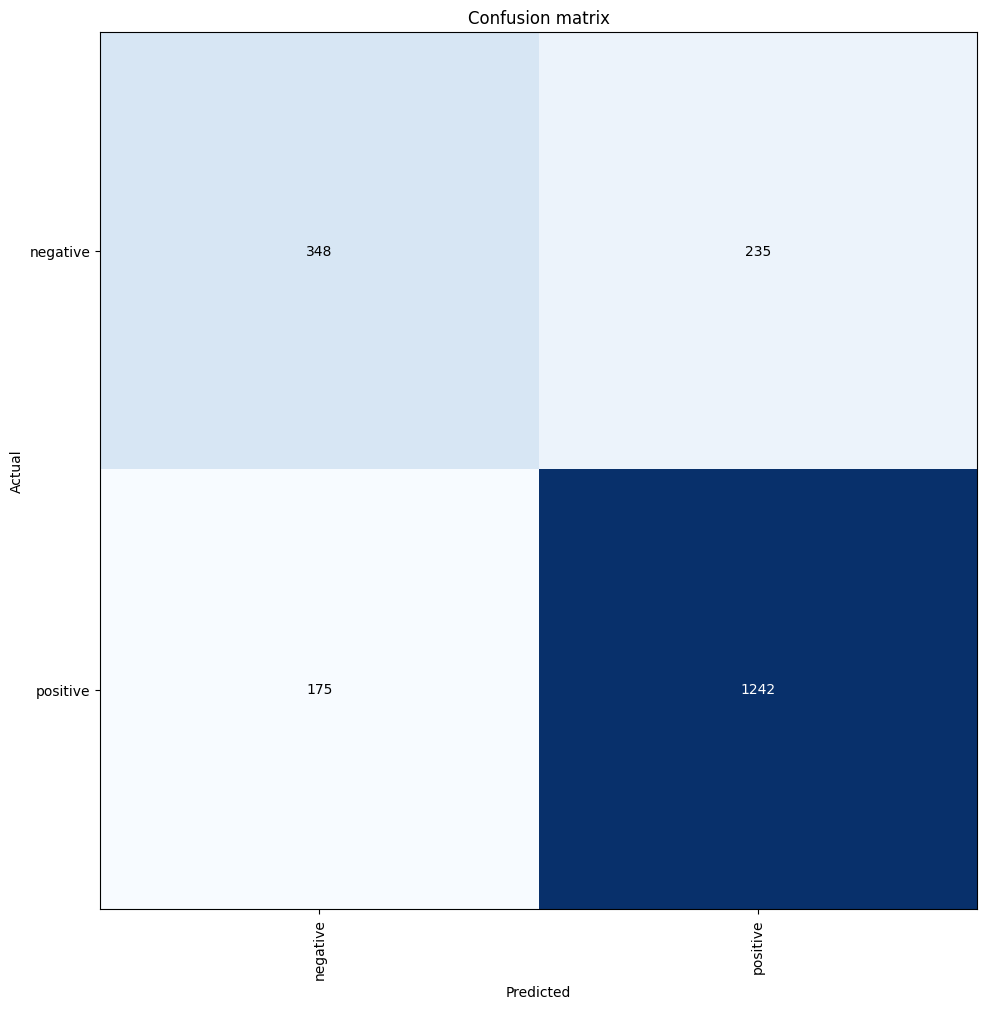

In [31]:
learn.fine_tune(1) #3rd Epoch
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix( figsize = (10,10)) # Conf matrix after 3rd

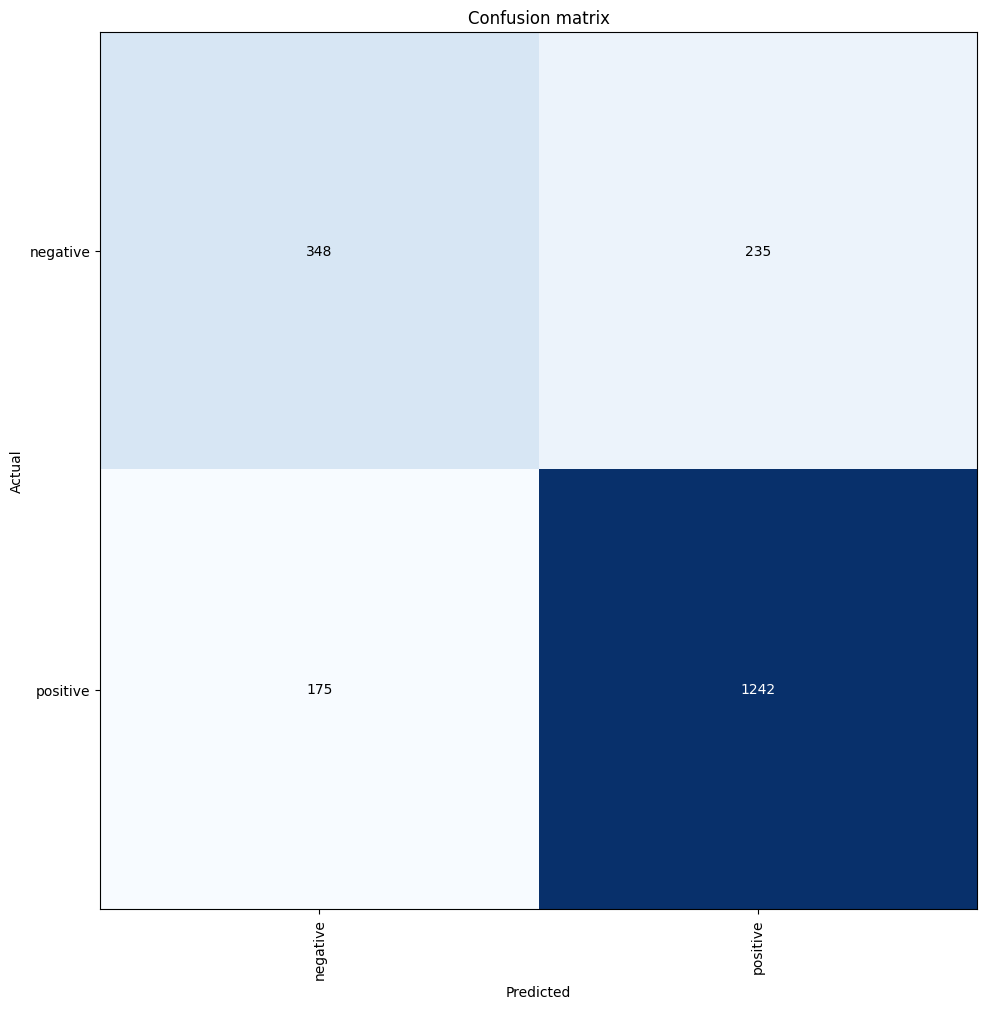

In [32]:
#learn.fine_tune(2) #4th and 5th epochs togethere
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix( figsize = (10,10)) # Conf matrix after 5th

In [34]:
classifier_path = os.path.join("/content/drive/MyDrive/EAI6010/lstm_classifier")
learn.export(classifier_path)
learner = []
learner = load_learner( classifier_path )
content = "This drug is bad"
prediction, prediction_possibility, prediction_possibilities = learner.predict( content )
print( f"prediction = {prediction}\n\n" )

prediction = negative


